# <font color='orangered'>Previsão de série temporal com TFT</font>

## Instalando e Carregando os Pacotes

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
# # https://www.tensorflow.org/
# !pip install -q tensorflow==2.12.0

In [3]:
# # https://pypi.org/project/yfinance/
# !pip install -q yfinance==0.2.22

In [4]:
# # https://pypi.org/project/ta/ # análise técnica de dados financeiros
# !pip install -q ta==0.10.2

In [5]:
# Imports
import ta
import sklearn
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from keras import layers
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")

C:\Users\mfran\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
plt.style.use('seaborn')

## Função Para Extração dos Dados em Tempo Real

https://finance.yahoo.com/

In [7]:
# Função
def extrai_dados(ticker):
    
    # Busca todos os dados a partir de 01/09/2019
    dados = yf.download(ticker, start = "2019-09-01")
    
    # Colunas do dataframe
    dados.columns = ["open", "high", "low", "close", "adj close", "volume"]
    
    # Data como índice
    dados.index.name = "date"
    
    return dados

In [8]:
# Extração dos dados
df = extrai_dados("AMZN")

[*********************100%***********************]  1 of 1 completed


## Função Para Engenharia de Atributos de Dados Financeiros

In [9]:
# Função para engenharia de atributos
def func_engenharia_atributos(df):

    # Cópia do dataframe
    df_copy = df.copy()

    # Cria a variável com o retorno (mudança percentual do fechamento - close)
    # Essa será nossa variável alvo
    df_copy["retorno"] = df_copy["close"].pct_change(1)

    # Shift das colunas de preço do ativo financeiro
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    # Shift da coluna Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    # Simple Moving Average (SMA)
    df_copy["SMA 25"] = df_copy[["close"]].rolling(25).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    df_copy["MSD 25"] = df_copy["retorno"].rolling(25).std().shift(1)
    df_copy["MSD 60"] = df_copy["retorno"].rolling(60).std().shift(1)

    # Volume Weighted Average Price (VWAP) Volume do preço médio ponderado
    vwap = ta.volume.VolumeWeightedAveragePrice(high = df['high'],
                                                low = df['low'],
                                                close = df['close'],
                                                volume = df['volume'],
                                                window = 5)
    
    df_copy["VWAP"] = vwap.vwap.shift(1)

    # Relative Strength Index (RSI)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    
    df_copy["RSI"] = RSI.rsi().shift(1)

    return df_copy.dropna()

In [10]:
# Engenharia de atributos
df = func_engenharia_atributos(df)

In [11]:
df.tail(2)

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 25,SMA 60,MSD 25,MSD 60,VWAP,RSI
date,,,,,,,,,,,,,,,,,,
2024-11-06,200.009995,207.550003,199.139999,207.089996,207.089996,72292200,0.038045,196.039993,199.820007,195.990005,199.500000,30564800.0,188.2112,184.052167,0.019017,0.017937,194.501701,70.419081
2024-11-07,207.440002,212.250000,207.190002,210.050003,210.050003,52820000,0.014293,200.009995,207.550003,199.139999,207.089996,72292200.0,189.1044,184.666500,0.020213,0.018362,196.918176,80.068730


> Divisão dos Dados em Treino, Validação e Teste

In [12]:
# Usar o gráfico que plota a cotação das principais colunas

In [13]:
# Percentual de split de treino e validação
split = int(0.80*len(df))
split_val = int(0.90*len(df))

In [14]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'retorno', 'op',
       'hi', 'lo', 'clo', 'vol', 'SMA 25', 'SMA 60', 'MSD 25', 'MSD 60',
       'VWAP', 'RSI'],
      dtype='object')

In [15]:
# Dataset de treino
x_treino = df[["VWAP", "RSI", "SMA 60", "op", "MSD 60"]].iloc[:split,:]
y_treino = df[['close']].iloc[:split,:]

In [16]:
# Dataset de validação
x_valid = df[["VWAP", "RSI", "SMA 60", "op", "MSD 60"]].iloc[split:split_val,:]
y_valid = df[['close']].iloc[split:split_val,:]

In [17]:
# Dataset de teste
x_teste = df[["VWAP", "RSI", "SMA 60", "op", "MSD 60"]].iloc[split_val:,:]
y_teste = df[['close']].iloc[split_val:,:]

## Padronização

In [18]:
# Cria o padronizador
sc = StandardScaler()

In [19]:
# Fit e transform nos dados de treino
x_treino_sc = sc.fit_transform(x_treino)

In [20]:
# Transform nos dados de validação
x_valid_sc = sc.transform(x_valid)

In [21]:
# Transform nos dados de teste
x_teste_sc = sc.transform(x_teste)

## Ajuste no Formato dos Dados

In [22]:
# Função para ajustar o formato dos dados
def ajusta_formato_dados(X_s, y_s, lag):

    if len(X_s) != len(y_s):
        print("Warnings")

    X_train = []
    
    for variable in range(0, X_s.shape[1]):
        
        X = []
        
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        
        X_train.append(X)
    
    X_train, np.array(X_train)
    
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    y_train = []
    
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    
    y_train = np.concatenate(y_train, axis = 0)
    
    return X_train, y_train

In [23]:
# Valor do Lag
lag = 5

In [24]:
# Aplica a função nos dados de treino
x_treino_final, y_treino_final = ajusta_formato_dados(x_treino_sc, y_treino.values, lag)

In [25]:
# Aplica a função nos dados de validação
x_valid_final, y_valid_final = ajusta_formato_dados(x_valid_sc, y_valid.values, lag)

In [26]:
# Aplica a função nos dados de teste
x_teste_final, y_teste_final = ajusta_formato_dados(x_teste_sc, y_teste.values, lag)

In [27]:
print(f"Shape dos dados de treino: {x_treino_final.shape}")
print(f"Shape dos dados de validação: {x_valid_final.shape}")
print(f"Shape dos dados de teste: {x_teste_final.shape}")

Shape dos dados de treino: (991, 5, 5)
Shape dos dados de validação: (119, 5, 5)
Shape dos dados de teste: (120, 5, 5)


## Construção do Modelo Temporal Fusion Transformer

In [28]:
# Função do transformer encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    
    # Normalização
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    
    # Atenção
    x = layers.MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x, x)
    
    # Dropout
    x = layers.Dropout(dropout)(x)
    
    # Camadas e dados
    res = x + inputs

    # Feed Forward 
    x = layers.LayerNormalization(epsilon = 1e-6)(res)
    x = layers.Conv1D(filters = ff_dim, kernel_size = 1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
    
    return x + res

A função abaixo é usada para construir o modelo final com LSTM, GRU e Transformer.

In [29]:
# Função de criação do modelo
def cria_modelo(input_shape, 
                head_size, 
                num_heads, 
                ff_dim, 
                num_transformer_blocks, 
                mlp_units, 
                dropout = 0, 
                mlp_dropout = 0):
    
    inputs = keras.Input(shape = input_shape)
    
    x = inputs
    
    x = layers.LSTM(10, return_sequences = True)(x)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GRU(120, return_sequences = False)(x)
    
    x = layers.Dropout(mlp_dropout)(x)
    
    x = layers.Dense(mlp_units, activation = "relu")(x)
    
    outputs = layers.Dense(1)(x)
    
    return keras.Model(inputs, outputs)

In [30]:
# Shape de entrada
input_shape = x_treino_final.shape[1:]

In [31]:
# Cria o modeloo
modelo = cria_modelo(input_shape,
                     head_size = 16,
                     num_heads = 1,
                     ff_dim = 4,
                     num_transformer_blocks = 1,
                     mlp_units = 130,
                     dropout = 0.2,
                     mlp_dropout = 0.25)

In [32]:
# Compila o modelo
modelo.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam())

In [33]:
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 5, 10)        640         ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 10)       20          ['lstm[0][0]']                   
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 10)       698         ['layer_normalization[0][0]',

In [34]:
# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]

In [35]:
%%time

# Treinamento do modelo
modelo.fit(x_treino_final,
           y_treino_final,
           validation_data = (x_valid_final, y_valid_final),
           epochs = 30,
           batch_size = 5,
           callbacks = callbacks)

Epoch 1/30
199/199 [==============================] - 9s 16ms/step - loss: 4573.1685 - val_loss: 1219.1946
Epoch 2/30
199/199 [==============================] - 2s 12ms/step - loss: 823.6332 - val_loss: 1111.2079
Epoch 3/30
199/199 [==============================] - 2s 11ms/step - loss: 315.6175 - val_loss: 238.1751
Epoch 4/30
199/199 [==============================] - 2s 12ms/step - loss: 173.4959 - val_loss: 207.7954
Epoch 5/30
199/199 [==============================] - 2s 12ms/step - loss: 133.4288 - val_loss: 161.1425
Epoch 6/30
199/199 [==============================] - 3s 14ms/step - loss: 131.4128 - val_loss: 166.1973
Epoch 7/30
199/199 [==============================] - 3s 13ms/step - loss: 121.0171 - val_loss: 193.3421
Epoch 8/30
199/199 [==============================] - 2s 12ms/step - loss: 117.9912 - val_loss: 131.7606
Epoch 9/30
199/199 [==============================] - 2s 11ms/step - loss: 123.0345 - val_loss: 107.4115
Epoch 10/30
199/199 [==============================]

<Axes: >

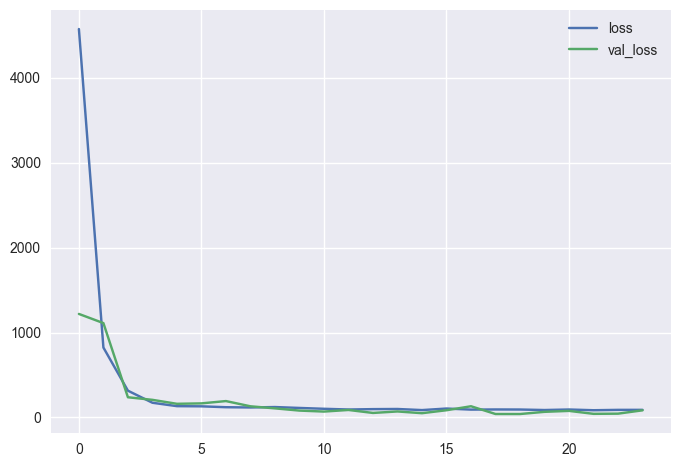

In [36]:
pd.DataFrame(modelo.history.history).plot()

In [37]:
pred = modelo.predict(x_teste_final)

4/4 [==============================] - 1s 9ms/step


In [38]:
score = np.sqrt(metrics.mean_squared_error(pred, y_teste_final))

In [39]:
print("Score (RMSE): {}".format(score))

Score (RMSE): 13.442478097441064


In [40]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
# Imprime as métricas
MSE = mean_squared_error(y_teste_final, pred)
print('MSE:', MSE)

RMSE = mean_squared_error(y_teste_final, pred, squared = False)
print('RMSE:', RMSE)

MAPE = MAPE(y_teste_final, pred)
print('MAPE:', MAPE)

MSE: 180.70021740018274
RMSE: 13.442478097441064
MAPE: 6.166365898900038


In [42]:
y_pred_treino = np.concatenate((np.zeros([lag,1]), modelo.predict(x_treino_final)), axis = 0)

31/31 [==============================] - 0s 6ms/step


In [43]:
y_pred_valid = np.concatenate((np.zeros([lag,1]), modelo.predict(x_valid_final)), axis = 0)

4/4 [==============================] - 0s 10ms/step


In [44]:
y_pred_teste = np.concatenate((np.zeros([lag,1]), modelo.predict(x_teste_final)), axis = 0)

4/4 [==============================] - 0s 8ms/step


In [45]:
# Concatena as previsões em treino, valid e teste como previsão final
df["prediction"] = np.concatenate((y_pred_treino, y_pred_valid, y_pred_teste), axis = 0)

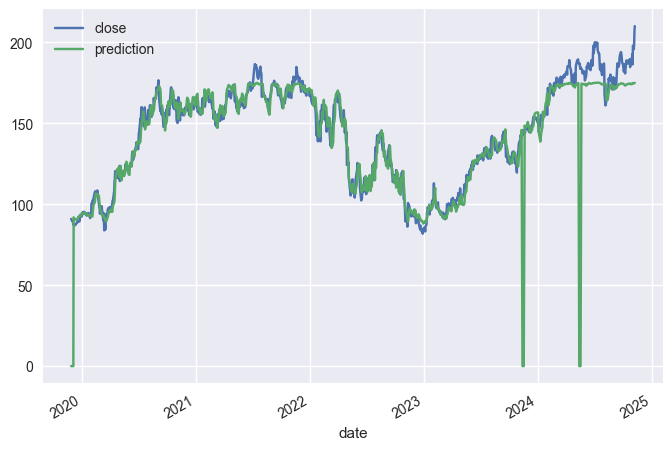

In [46]:
df[['close', 'prediction']].plot()
plt.show();

In [47]:
# Calcula a estratégia
df["strategy"] = df["retorno"] * np.sign(df["prediction"].shift(1))

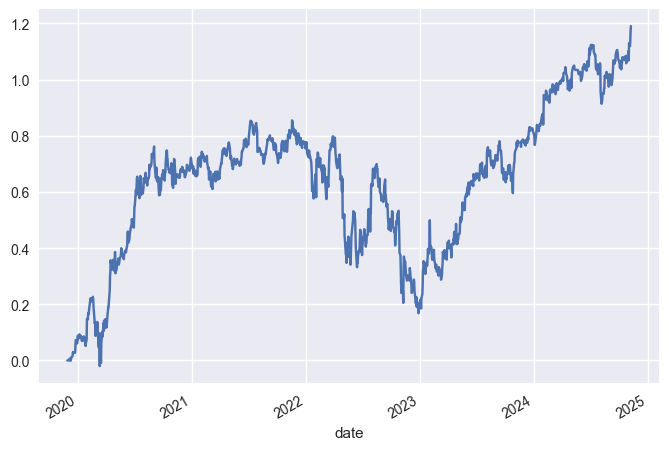

In [48]:
# Plot do acumulado
df["strategy"].iloc[:].cumsum().plot()
plt.show()

In [49]:
amzn = df[["close", "prediction"]].reset_index()
amzn1 = (amzn["date"] > '2024-08-01')
amzn2 = amzn[amzn1]
amazon = amzn2.rename(columns={'prediction':'AMZN_TFT'})

In [50]:
amazon.tail()

,date,close,AMZN_TFT
1240,2024-11-01,197.929993,174.832367
1241,2024-11-04,195.779999,174.672302
1242,2024-11-05,199.500000,174.805206
1243,2024-11-06,207.089996,174.867874
1244,2024-11-07,210.050003,174.977936


In [51]:
amazon.to_csv('amazon_tft.csv')